# AIR QUALITY

0 Date (DD/MM/YYYY)

1 Time (HH.MM.SS)

12 Temperature in C

13 Relative Humidity

14 AH Absolute Humidity

In [123]:
import os
import numpy
import pandas
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import tensorflow
import seaborn

random_seed = 32
numpy.random.seed(random_seed)
tensorflow.random.set_seed(random_seed)
tensorflow.keras.utils.set_random_seed(random_seed)
tensorflow.config.experimental.enable_op_determinism()

In [124]:
# TRAINING
n_test_samples = 8
n_validation_samples = 14

# DECLARE NET
max_neurons = 4
PATIENCE = 50
MAX_EPOCHS = 10*PATIENCE
LEARNING_RATE = 0.01
HIDDEN_ACTIVATION = 'linear'
MODEL_LOSS = 'val_loss'
MIN_IMPROVEMENT = 0.05
this_is_zero = 0.01
error_bar = 2.0

In [125]:
working_dir = os.getcwd()
notebooks_dir = os.path.dirname(working_dir)
root_dir = os.path.dirname(notebooks_dir)
data_dir = os.path.join(root_dir, 'datasets')
air_quality_file = os.path.join(data_dir, 'air_quality.csv')
df = pandas.read_csv(air_quality_file, sep=';', decimal=',')

df['Date'] = pandas.to_datetime(df['Date'], format='%d/%m/%Y')
df.loc[df['T'] == -200, 'T'] = numpy.nan
df.loc[df['RH'] < 0.0, 'RH'] = numpy.nan
df.loc[df['AH'] < 0.0, 'AH'] = numpy.nan
df_day = df[['Date', 'T', 'RH', 'AH']].groupby('Date').mean()

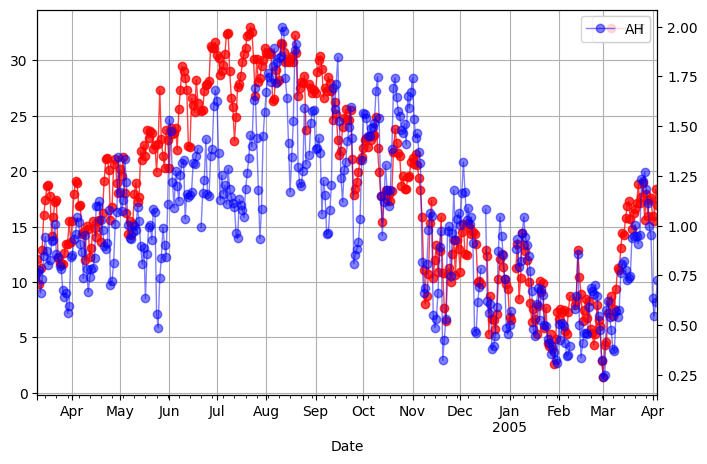

In [126]:
fig = pyplot.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
_ = df_day.plot(y='AH', ax=ax2, lw=1, marker='o', color='blue', alpha=0.5)
_ = df_day.plot(y='T', ax=ax, lw=1, marker='o', color='red', alpha=0.75)
_ = ax.grid()

In [127]:
df_day['T_d1'] = df_day['T'].shift(-1)
df_day['T_l1'] = df_day['T'].shift(1)
df_day['T_l2'] = df_day['T'].shift(2)
df_day['T_l3'] = df_day['T'].shift(3)
df_day['RH_l1'] = df_day['RH'].shift(1)
df_day['RH_l2'] = df_day['RH'].shift(2)
df_day['RH_l3'] = df_day['RH'].shift(3)
df_day['AH_l1'] = df_day['AH'].shift(1)
df_day['AH_l2'] = df_day['AH'].shift(2)
df_day['AH_l3'] = df_day['AH'].shift(3)
complete_cases = ~df_day.isna().any(axis=1)
dfn = df_day[complete_cases]

In [128]:
df_day

,T,RH,AH,T_d1,T_l1,T_l2,T_l3,RH_l1,RH_l2,RH_l3,AH_l1,AH_l2,AH_l3
Date,,,,,,,,,,,,,
2004-03-10,12.033333,54.900000,0.765633,9.837500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-03-11,9.837500,64.075000,0.775767,11.287500,12.033333,NaN,NaN,54.900000,NaN,NaN,0.765633,NaN,NaN
2004-03-12,11.287500,51.095833,0.663104,12.866667,9.837500,12.033333,NaN,64.075000,54.900000,NaN,0.775767,0.765633,NaN
2004-03-13,12.866667,51.533333,0.732296,16.012500,11.287500,9.837500,12.033333,51.095833,64.075000,54.900000,0.663104,0.775767,0.765633
2004-03-14,16.012500,48.850000,0.849671,17.366667,12.866667,11.287500,9.837500,51.533333,51.095833,64.075000,0.732296,0.663104,0.775767
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-03-31,17.550000,50.083333,0.951917,15.929167,17.433333,15.916667,17.933333,54.037500,62.537500,60.766667,0.996762,1.116463,1.186071
2005-04-01,15.929167,35.962500,0.636529,15.483333,17.550000,17.433333,15.916667,50.083333,54.037500,62.537500,0.951917,0.996762,1.116463
2005-04-02,15.483333,32.225000,0.546167,18.383333,15.929167,17.550000,17.433333,35.962500,50.083333,54.037500,0.636529,0.951917,0.996762


In [129]:
x_cols = ['T', 'T_l1','T_l2','T_l3','AH_l1','AH_l2','AH_l3', 'RH_l1','RH_l2','RH_l3']
y_cols = ['T_d1']
Y_name = 'T_d1'

# SAMPLING
X_trn = dfn.iloc[:-(n_validation_samples + n_test_samples)][x_cols].to_numpy()
X_val = dfn.iloc[-(n_validation_samples + n_test_samples):-n_test_samples][x_cols].to_numpy()
X_tst = dfn[x_cols].to_numpy()
Y_trn = dfn.iloc[:-(n_validation_samples + n_test_samples)][y_cols].to_numpy()
Y_val = dfn.iloc[-(n_validation_samples + n_test_samples):-n_test_samples][y_cols].to_numpy()
Y_tst = dfn[y_cols].to_numpy()

# SCALING X
X_scaler = StandardScaler()
X_scaler = X_scaler.fit(X_trn)
X_trn_scaled = X_scaler.transform(X_trn)
X_val_scaled = X_scaler.transform(X_val)
X_tst_scaled = X_scaler.transform(X_tst)

# SCALING Y
Y_scaler = StandardScaler()
Y_scaler = Y_scaler.fit(Y_trn)
Y_trn_scaled = Y_scaler.transform(Y_trn)
Y_val_scaled = Y_scaler.transform(Y_val)

is_best_net = False
best_loss = 1000.0
best_val_loss = 1000.0
previous_val_loss = 1000.0
training_result_list = []
for n_neurons in numpy.arange(max_neurons) + 1:
    inputs = tensorflow.keras.Input(shape=(X_trn_scaled.shape[1]))
    hidden = tensorflow.keras.layers.Dense(n_neurons, activation=HIDDEN_ACTIVATION)(inputs)
    outputs = tensorflow.keras.layers.Dense(Y_trn_scaled.shape[1], activation='linear')(hidden)
    model_name = 'FORECAST_{}_{}'.format(HIDDEN_ACTIVATION, n_neurons)
    my_net = tensorflow.keras.Model(inputs=inputs, outputs=outputs, name=model_name)
    my_net.compile(optimizer=tensorflow.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE), loss='mse')
    es_callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=PATIENCE, restore_best_weights=True)
    history = my_net.fit(X_trn_scaled, Y_trn_scaled, epochs=MAX_EPOCHS, validation_data=(X_val_scaled, Y_val_scaled), batch_size=X_trn_scaled.shape[0], callbacks=[es_callback], verbose=0)
    
    hyperparameter_residual = Y_tst - Y_scaler.inverse_transform(my_net.predict(X_tst_scaled, verbose=0))
    test_mean_residual = hyperparameter_residual.mean()
    test_std_residual = hyperparameter_residual.std()
    residual_loss = test_mean_residual**2

    model_loss = (history.history['loss'][-1] + residual_loss)/2
    model_val_loss = (history.history['val_loss'][-1] + residual_loss)/2
    epochs = len(history.history['val_loss'])

    has_improved_val_loss = False
    loss_improvement = 1.0 - model_val_loss/previous_val_loss

    if not is_best_net or loss_improvement >= MIN_IMPROVEMENT: # keep adding neurons

        is_best_net = (model_loss <= best_loss) and (model_val_loss < best_val_loss) and (numpy.abs(test_mean_residual) <= this_is_zero)

        if is_best_net:
                best_loss = model_loss
                best_val_loss = model_val_loss
                best_net = my_net
                best_history = history
                best_text = '***BEST NET!***'
                best_name = model_name
                best_epochs = epochs
                best_mean_residual = test_mean_residual
                best_std_residual = test_std_residual
                best_residual_loss = residual_loss
        else:
            best_text = ''
    else:
        print('EXTRA NEURON DIDNT IMPROVE NET {:.0f}% GAIN'.format(100.0*loss_improvement))
        break
    result_dict = {'model_name': model_name, 'epochs': epochs, 'model_loss': model_loss, 'model_val_loss': model_val_loss, 'best_net':is_best_net, 'history': history}
    training_result_list.append(result_dict)
    previous_val_loss = model_val_loss
    print(f'{model_name} RESULTS > EPOCHS: {epochs} LOSS: {model_loss:.3f} VAL_LOSS: {model_val_loss:.3f} IMPROVEMENT {100.0*loss_improvement:.0f}% MEAN_RESIDUAL {test_mean_residual:.3f} RESIDUAL LOSS {residual_loss:.3f} {best_text}')

FORECAST_linear_1 RESULTS > EPOCHS: 500 LOSS: 0.047 VAL_LOSS: 0.019 IMPROVEMENT 100% MEAN_RESIDUAL -0.012 RESIDUAL LOSS 0.000 ***BEST NET!***
FORECAST_linear_2 RESULTS > EPOCHS: 500 LOSS: 0.028 VAL_LOSS: 0.016 IMPROVEMENT 14% MEAN_RESIDUAL 0.011 RESIDUAL LOSS 0.000 ***BEST NET!***
FORECAST_linear_3 RESULTS > EPOCHS: 500 LOSS: 0.027 VAL_LOSS: 0.015 IMPROVEMENT 9% MEAN_RESIDUAL 0.010 RESIDUAL LOSS 0.000 ***BEST NET!***
EXTRA NEURON DIDNT IMPROVE NET -3% GAIN


In [130]:
if not is_best_net:
    best_loss = model_loss
    best_val_loss = model_val_loss
    best_net = my_net
    best_history = history
    best_name = model_name
    best_epochs = epochs
    best_mean_residual = test_mean_residual
    best_std_residual = test_std_residual
    best_residual_loss = residual_loss

Y_est_scaled = best_net.predict(X_tst_scaled, verbose=0)
Y_est = Y_scaler.inverse_transform(Y_est_scaled)
df_day.loc[complete_cases, ['Y_est']] = Y_est
df_day['residual'] = df_day['Y_est'] - df_day['T_d1']
df_day['rabs'] = df_day['residual'].abs()
df_day['upper_bound'] = df_day['Y_est'] + error_bar*best_std_residual
df_day['lower_bound'] = df_day['Y_est'] - error_bar*best_std_residual
df_day['goal'] = ((df_day[Y_name] >= df_day['lower_bound']) & (df_day[Y_name] <= df_day['upper_bound'])).astype(int)
model_r2_score = r2_score(df_day.loc[complete_cases, 'T_d1'].to_numpy(), df_day.loc[complete_cases, 'Y_est'].to_numpy())

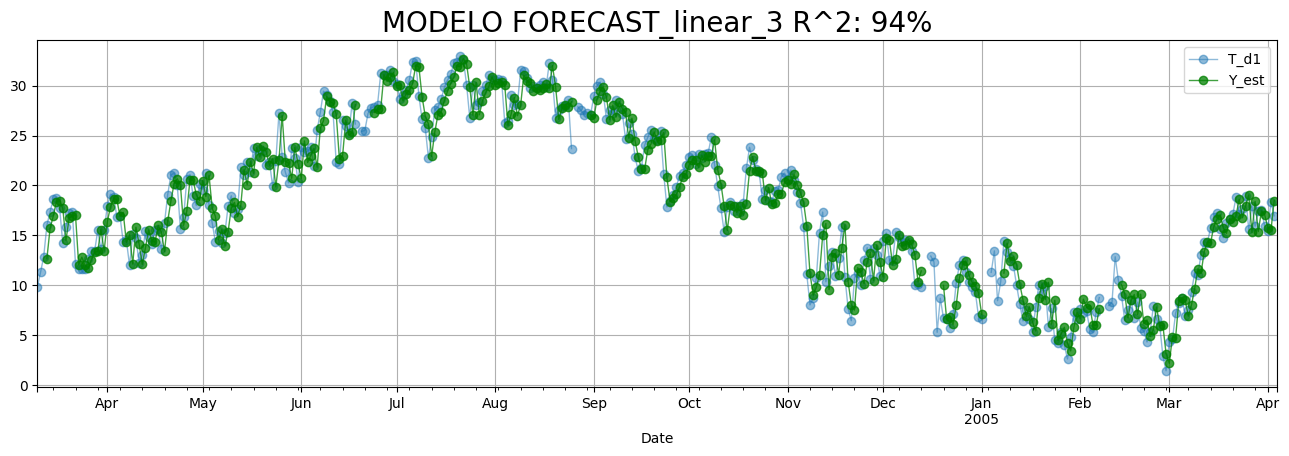

In [131]:
fig = pyplot.figure(figsize=(16, 4.5))
ax = fig.add_subplot(111)
_ = df_day.plot(y='T_d1', ax=ax, lw=1, marker='o', alpha=0.5)
_ = df_day.plot(y='Y_est', ax=ax, lw=1, marker='o', alpha=0.75, color='green')
_ = ax.grid()
_ = ax.set_title('MODELO {} R^2: {:.0f}%'.format(best_name, 100.0*model_r2_score), size=20)

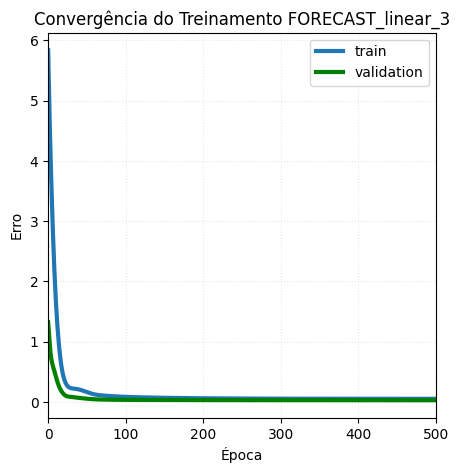

In [132]:
# plot training convergence
training_loss = best_history.history['loss']
validation_loss = best_history.history['val_loss']

fig = pyplot.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
_ = ax.plot(training_loss, label='train', linewidth=3)
_ = ax.plot(validation_loss, label='validation', linewidth=3, color='green')
_ = ax.set_title(f'Convergência do Treinamento {best_name}')
_ = ax.set_xlabel('Época')
_ = ax.set_ylabel('Erro')
_ = ax.legend()
_ = ax.grid(alpha=0.3, linestyle=':')
_ = ax.set_xlim(0, len(training_loss))

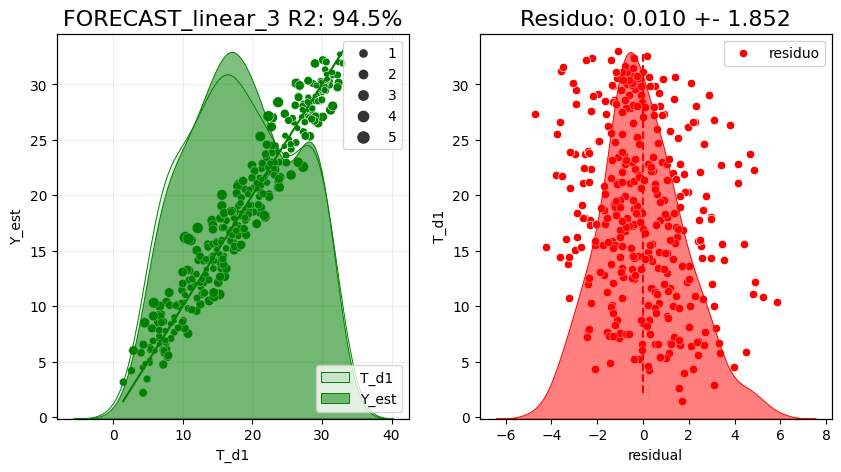

In [133]:
# STABLE RESIDUAL PLOT
r_mean = df_day.residual.median()
r_std = df_day.residual.std()
r2 = r2_score(df_day.loc[complete_cases, Y_name].to_numpy(), df_day.loc[complete_cases, 'Y_est'].to_numpy())

fig = pyplot.figure(figsize=(10, 5))
ax = fig.add_subplot(121)
lines = seaborn.scatterplot(data=df_day, x=Y_name, y='Y_est', size='rabs', ax=ax, color='green')
_ = ax.plot([df_day[Y_name].min(), df_day[Y_name].max()], [df_day[Y_name].min(), df_day[Y_name].max()], color='green')
_ = ax.grid(alpha=0.2)
_ = ax.set_title('{} R2: {:.1f}%'.format(best_name,100.0*r2), size=16)
ax2 = ax.twinx()
_ = seaborn.kdeplot(data=df_day, x=Y_name, ax=ax2, label=Y_name, color='green', fill=True, alpha=0.1, linewidth=0.7)
_ = seaborn.kdeplot(data=df_day, x='Y_est', ax=ax2, label='Y_est', color='green', fill=True, alpha=0.5, linewidth=0.7)
_ = ax2.set_ylabel('')
_ = ax2.set_yticks([])
_ = ax.legend(loc='upper right')
_ = ax2.legend(loc='lower right')
ax3 = fig.add_subplot(122)
_ = seaborn.scatterplot(data=df_day, x='residual', y=Y_name, ax=ax3, label='residuo', color='red')
ax4 = ax3.twinx()
_ = seaborn.kdeplot(data=df_day, x='residual', ax=ax4, label='residuo', color='red', fill=True, alpha=0.5, linewidth=0.7)
_ = ax4.grid(alpha=0.2)
_ = ax4.set_ylabel('')
_ = ax4.set_yticks([])
_ = ax4.set_title(f'Residuo: {best_mean_residual:.3f} +- {best_std_residual:.3f}', size=16)
_ = ax3.plot([best_mean_residual, best_mean_residual], [df_day.Y_est.min(), df_day.Y_est.max()], '--', color='red')

In [134]:
df_day.iloc[-n_test_samples:, :][[Y_name, 'lower_bound', 'Y_est', 'upper_bound', 'residual', 'rabs', 'goal']]

,T_d1,lower_bound,Y_est,upper_bound,residual,rabs,goal
Date,,,,,,,
2005-03-28,15.916667,14.696382,18.401201,22.106021,2.484535,2.484535,1
2005-03-29,17.433333,11.672224,15.377043,19.081862,-2.056291,2.056291,1
2005-03-30,17.550000,13.732168,17.436987,21.141806,-0.113013,0.113013,1
2005-03-31,15.929167,13.385177,17.089996,20.794816,1.160830,1.160830,1
2005-04-01,15.483333,12.064456,15.769276,19.474095,0.285942,0.285942,1
2005-04-02,18.383333,11.814576,15.519395,19.224214,-2.863938,2.863938,1
2005-04-03,16.960000,14.789066,18.493885,22.198704,1.533885,1.533885,1
2005-04-04,NaN,NaN,NaN,NaN,NaN,NaN,0


In [135]:
best_net.summary()

Model: "FORECAST_linear_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 10)]              0         
                                                                 
 dense_48 (Dense)            (None, 3)                 33        
                                                                 
 dense_49 (Dense)            (None, 1)                 4         
                                                                 
Total params: 37 (148.00 Byte)
Trainable params: 37 (148.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [136]:
best_weights = best_net.get_weights()

In [137]:
best_weights[0]

array([[ 0.24650782,  0.22912893,  1.0444359 ],
       [ 0.27944127,  0.13635702, -0.66962206],
       [-0.2021018 ,  0.21505147,  0.33201036],
       [ 0.22953847,  0.24874677, -0.54466677],
       [-0.6062005 ,  0.46495795,  0.32178968],
       [-0.12342064, -0.07317901,  0.12026398],
       [ 0.44949868,  0.2854153 , -0.6546198 ],
       [ 0.3935656 , -0.71624357,  0.15676342],
       [-0.08445056, -0.1081466 ,  0.18870495],
       [-0.35211366,  0.14789878,  0.2033763 ]], dtype=float32)

In [138]:
best_weights[1]

array([-0.00030748,  0.00015246,  0.00024012], dtype=float32)

In [139]:
best_weights[2]

array([[0.7502944 ],
       [0.52397484],
       [0.64984137]], dtype=float32)

In [140]:
best_weights[3]

array([-5.3162953e-06], dtype=float32)